# Imports

In [94]:
import cv2
import torch
import pathlib
import numpy as np
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torchinfo import summary
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# Preprocessing

# Datasets

In [95]:
class DroneDataset(Dataset):

    def __init__(self, path, albumentations):
        self.img_paths = list(pathlib.Path(f"{path}/img").glob("*.jpg"))
        self.mask_paths = list(pathlib.Path(f"{path}/mask").glob("*.png"))
        self.albumentations = albumentations
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, i):
        img = cv2.imread(str(self.img_paths[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[i]), cv2.IMREAD_GRAYSCALE)
        a = self.albumentations(image=img, mask=mask)
        img = T.ToTensor()(a['image'])
        mask = torch.from_numpy(a['mask']).long()

        return img, mask

In [96]:
t_train = A.Compose([A.Resize(400, 600), A.VerticalFlip(), A.HorizontalFlip(), A.GaussNoise()])

t_val = A.Compose([A.Resize(400, 600), A.VerticalFlip(), A.HorizontalFlip(), A.GaussNoise()])

t_test = A.Compose([A.Resize(400, 600)])

#datasets
train_set = DroneDataset("./data/drone-dataset/train", t_train)
val_set = DroneDataset("./data/drone-dataset/val", t_val)
test_set = DroneDataset("./data/drone-dataset/test", t_test)

train_loader = DataLoader(train_set, batch_size=3, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=3, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=3, shuffle=True, drop_last=True)

# Model

In [97]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        auxiliary_x = self.resnet.layer1(x)
        x = self.resnet.layer2(auxiliary_x)
        #auxiliary_x = self.resnet.layer3(x)
        #x = self.resnet.layer4(auxiliary_x)

        return x, auxiliary_x

In [98]:
class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels, int(in_channels / len(pools)), 1, 1, 0, 1, bias=False)
            )
            for p in pools
        ])

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            layer_output = pooling_layer(x)
            outputs.append(F.interpolate(layer_output, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)

In [99]:
class SegmentationClassifier(nn.Module):
    
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.UpsamplingBilinear2d(scale_factor=scale_factor)
        )

    def forward(self, x):
        return self.segmentation(x)

In [100]:
class PSPNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.feature_extractor = CustomResNet()
        self.pyramid_pooling = PyramidPoolingModule(input_shape=(int(input_shape[0] / 8), int(input_shape[1] / 8)), in_channels=512, pools = (6, 3, 2, 1))
        self.classifier = SegmentationClassifier(in_channels=1024, out_channels=n_classes, scale_factor=8)
        self.aux_classifier = SegmentationClassifier(in_channels=256, out_channels=n_classes, scale_factor=4)
        
    def forward(self, x):
        encoder_outputs, encoder_auxiliary = self.feature_extractor(x)
        pyramid_outputs = self.pyramid_pooling(encoder_outputs)
        return self.classifier(pyramid_outputs), self.aux_classifier(encoder_auxiliary)

In [101]:
model = PSPNet(input_shape=(400,600), n_classes=23)
summary(model, input_size=(3, 3, 400, 600))

Layer (type:depth-idx)                             Output Shape              Param #
PSPNet                                             [3, 23, 400, 600]         --
├─CustomResNet: 1-1                                [3, 512, 50, 75]          --
│    └─ResNet: 2-1                                 --                        24,112,104
│    │    └─Conv2d: 3-1                            [3, 64, 200, 300]         9,408
│    │    └─BatchNorm2d: 3-2                       [3, 64, 200, 300]         128
│    │    └─ReLU: 3-3                              [3, 64, 200, 300]         --
│    │    └─MaxPool2d: 3-4                         [3, 64, 100, 150]         --
│    │    └─Sequential: 3-5                        [3, 256, 100, 150]        215,808
│    │    └─Sequential: 3-6                        [3, 512, 50, 75]          1,219,584
├─PyramidPoolingModule: 1-2                        [3, 1024, 50, 75]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └

# Training

In [102]:
class DeepSupervisionLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, output, target):
        loss = self.cross_entropy(output[0], target)
        aux_loss = self.cross_entropy(output[1], target)
        return loss + self.alpha * aux_loss

In [103]:
criterion = DeepSupervisionLoss(alpha=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [104]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    model.to(device)
    train_loss = []
    val_loss = []
    for e in tqdm(range(epochs)):
        model.train()
        epoch_train_loss = []
        for i, (img, mask) in enumerate(train_loader):
            img = img.to(device)
            mask = mask.to(device)
            output = model(img)
            loss = criterion(output, mask)
            epoch_train_loss.append(loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        epoch_val_loss = []
        with torch.inference_mode():
            for i, (img, mask) in enumerate(val_loader):
                img = img.to(device)
                mask = mask.to(device)
                output = model(img)
                loss = criterion(output, mask)
                epoch_val_loss.append(loss.cpu().detach().numpy())
        
        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))

        print(f"Epoch {e} | Loss: {np.mean(epoch_train_loss)} | Val Loss: {np.mean(epoch_val_loss)}")
    
    return train_loss, val_loss

In [124]:
train_loss, val_loss = fit(120, model, train_loader, val_loader, criterion, optimizer)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.9795451760292053 | Val Loss: 1.0577837228775024
Epoch 1 | Loss: 0.9696465730667114 | Val Loss: 1.2232435941696167
Epoch 2 | Loss: 0.9695349335670471 | Val Loss: 0.9039150476455688
Epoch 3 | Loss: 0.9597967267036438 | Val Loss: 1.2414852380752563
Epoch 4 | Loss: 0.8766370415687561 | Val Loss: 1.0294849872589111
Epoch 5 | Loss: 0.8967821002006531 | Val Loss: 1.241807460784912
Epoch 6 | Loss: 0.8763212561607361 | Val Loss: 1.4131826162338257
Epoch 7 | Loss: 0.8881747126579285 | Val Loss: 1.5425026416778564
Epoch 8 | Loss: 0.8522990942001343 | Val Loss: 0.9240520596504211
Epoch 9 | Loss: 0.8418921232223511 | Val Loss: 1.0028631687164307
Epoch 10 | Loss: 0.8181505799293518 | Val Loss: 1.674485445022583
Epoch 11 | Loss: 0.8361607789993286 | Val Loss: 1.0050106048583984
Epoch 12 | Loss: 0.9250304698944092 | Val Loss: 1.1831648349761963
Epoch 13 | Loss: 0.8774119019508362 | Val Loss: 0.9548438787460327
Epoch 14 | Loss: 0.8157795071601868 | Val Loss: 0.8250943422317505
Epoch 1

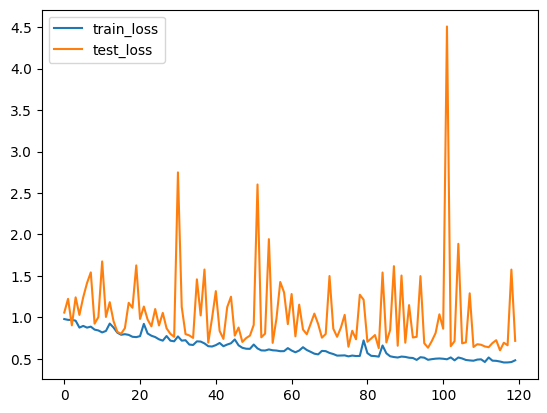

In [126]:
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="test_loss")
plt.legend()

In [125]:
torch.save(model.state_dict(), "./models/01_pspnet_drone_3.pth")

# Evaluation

## Result

In [108]:
def predict_image_mask(model, image):
    model.eval()
    model.to(device)
    image = image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output, _ = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

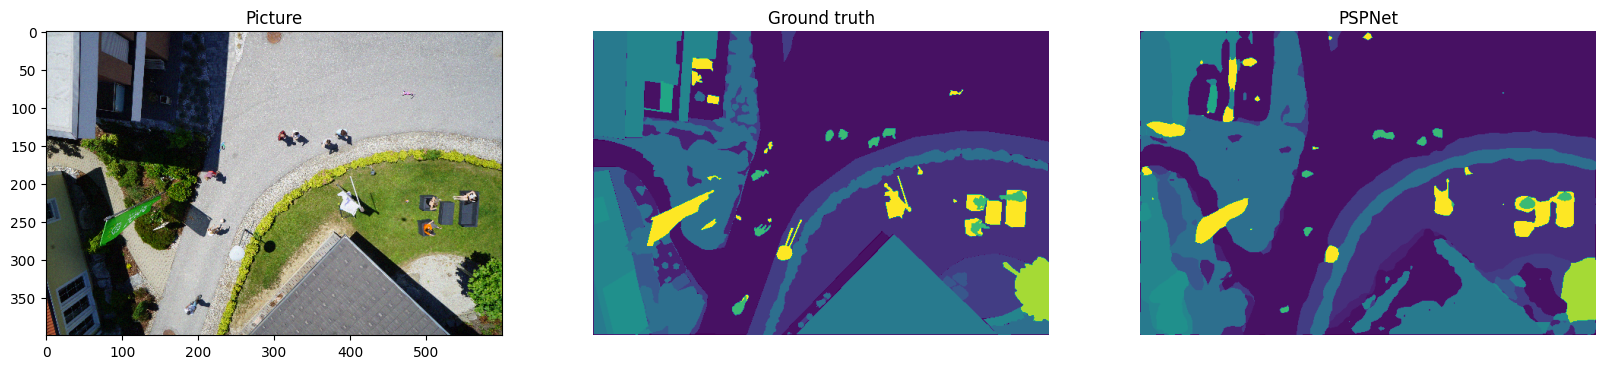

In [146]:
image, mask = train_set[30]
pred_mask = predict_image_mask(model, image)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(T.ToPILImage()(image))
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('PSPNet')
ax3.set_axis_off()